In [15]:
import pandas as pd
import numpy as np
import os
import nibabel as nib
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from utils import flatten
from utils import DataLoader3DT1GD ## the 2D one with slices t1_gd
from utils import DataLoader2DALL ## the 2D one with slices of t1_gd, flair and pre_gd
from utils import DataLoader2 ## no slices and all the modes
from utils import CustomDataset
from utils import visualize_slices
from utils import train_validate_model
from utils import multiclass_roc_auc_score
from utils import class_vs_rest_roc_auc_score
from utils import calculate_specificity
from utils import calculate_sensitivity
from utils import calculate_f1_score
from utils import calculate_accuracy
from utils import calculate_precision
from imblearn.over_sampling import SMOTE
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, ResNet50_Weights
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.models import resnet50, ResNet50_Weights
from tqdm import tqdm
from utils import test_model
from sklearn.metrics import confusion_matrix
import torchvision.transforms as T
import torchio
from torchio.transforms import (
    CropOrPad,
    OneOf,
    RescaleIntensity,
    RandomAffine,
    RandomElasticDeformation,
    RandomFlip,
    Compose,
)
from sklearn.utils.class_weight import compute_class_weight
from torchvision.models.video import mc3_18, MC3_18_Weights
from glob import glob
from utils import test_model3D

In [16]:
df = pd.read_excel('all_patients.xlsx')
df = df[df.shape_VoxelVolume > 125]
df.drop(df[df['labels'] == 3].index, inplace = True) ## dropping label of the call OTHERS
df.drop(df[df['number_annotations'] > 1].index, inplace = True)
df

,subjid,label,shape_Elongation,shape_Flatness,shape_LeastAxisLength,shape_MajorAxisLength,shape_Maximum2DDiameterColumn,shape_Maximum2DDiameterRow,shape_Maximum2DDiameterSlice,shape_Maximum3DDiameter,...,ngtdm_Busyness,ngtdm_Coarseness,ngtdm_Complexity,ngtdm_Contrast,ngtdm_Strength,Age,number_annotations,F,M,labels
0,Oslo01,1,0.829356,0.682981,8.512717,12.464063,14.866069,14.560220,12.529964,15.394804,...,158.977235,0.008929,0.302273,0.074659,0.008950,58,1,0,1,0
1,Oslo01,2,0.944143,0.900681,14.133927,15.692487,17.804494,19.416488,18.681542,19.467922,...,39.445794,0.007407,0.115448,0.010426,0.007130,58,1,0,1,0
4,Oslo02,4,0.849295,0.841082,8.703783,10.348315,10.816654,11.704700,11.704700,12.449900,...,14.239428,0.022868,0.159307,0.020316,0.023465,50,1,1,0,1
5,Oslo02,5,0.939828,0.821847,12.093804,14.715396,17.262677,17.888544,17.492856,18.000000,...,49.609354,0.008536,0.137901,0.028455,0.008212,50,1,1,0,1
7,Oslo03,1,0.930698,0.629604,10.914986,17.336268,20.615528,18.439089,19.416488,20.712315,...,43.648474,0.007781,0.123220,0.017415,0.007982,64,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2408,Stan_328,1,0.810571,0.325076,8.769420,26.976501,31.384710,28.160256,27.459060,33.075671,...,12.988427,0.019891,0.030104,0.000639,0.019768,53,1,0,1,1
2415,Stan_328,8,0.967496,0.597282,6.131668,10.265944,11.661904,12.369317,12.165525,12.688578,...,18.452502,0.024791,0.208465,0.046975,0.023205,53,1,0,1,1
2418,Stan_328,11,0.561746,0.506390,5.004740,9.883181,8.246211,11.704700,10.000000,12.124356,...,0.553323,0.468447,0.025263,0.000748,0.365681,53,1,0,1,1
2419,Stan_328,12,0.959775,0.756903,5.164755,6.823538,7.615773,8.602325,8.602325,8.602325,...,0.000000,1000000.000000,0.000000,0.000000,0.000000,53,1,0,1,1


## we have created a new folder called deep learning with all the folder with all the folder per patient labels as 0, 1 or 2 with tumors greater than 125mm3

In [17]:
df2 = df[['subjid']].join(df['label']).join(df['labels'])
#df2.to_excel('final_labels.xlsx')
df2

,subjid,label,labels
0,Oslo01,1,0
1,Oslo01,2,0
4,Oslo02,4,1
5,Oslo02,5,1
7,Oslo03,1,0
...,...,...,...
2408,Stan_328,1,1
2415,Stan_328,8,1
2418,Stan_328,11,1
2419,Stan_328,12,1


In [18]:
new_df = pd.DataFrame({'Subjid': df.iloc[:, 0], 'Tumor': df.iloc[:, 1], 'Labels': df.iloc[:, -1]})
new_df = new_df.drop_duplicates(subset='Subjid', keep='first')
new_df = new_df[new_df['Subjid'] != 'Oslo66']
y_patients = new_df['Labels']

In [19]:
df3 = pd.read_excel('final_labels.xlsx')
df3.set_index('subjid')
y = df3['labels']
len(y)

437

## lets see if the slices thing work

eto que e lo e manito (86, 54, 42)
This is indeed the input my men (86, 54)
This is indeed the input my men (86, 54)
This is indeed the input my men (86, 54)
This is indeed the input my men (86, 54)
This is indeed the input my men (86, 54)
This is indeed the input my men (86, 54)
This is indeed the input my men (86, 54)


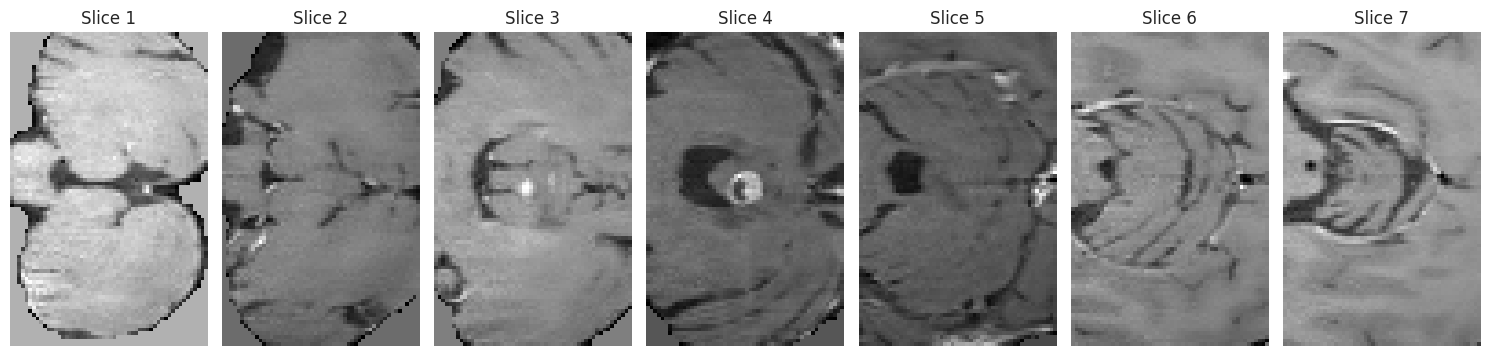

In [20]:
img_dir = f'/data/projects/TMOR/data/VeryFinalA/Oslo02/4/t1_gd.nii.gz'

visualize_slices(img_dir)

## create dataset torchio

In [21]:
scores = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI': [], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': [], 'Pre_mean': [], 'Pre_CI': [], 'Pre_sd': [], 'F1_mean': [], 'F1_CI': [], 'F1_sd': [], 'Accy_mean': [], 'Accy_CI': [], 'Accy_sd': []}

num_classes = len(np.unique(y))
sum_confusion_matrix_rf = np.zeros((num_classes, num_classes))

data_loader = DataLoader3DT1GD()

# Splitting into train, validation, and test sets
unique_patients = list(new_df['Subjid'])


# Splitting unique_patient_ids into trainval and test patient IDs
trainval_patient_ids, test_patient_ids = train_test_split(unique_patients, test_size=0.2, random_state=0, stratify = y_patients)

trainval_y = [new_df[new_df['Subjid'] == i]['Labels'].values[0] for i in trainval_patient_ids]

# Perform stratified shuffle split on train indices
#kf = KFold(n_splits=5, random_state=42, shuffle=True)
sss = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
fold_acc = []
fold_auc_tot = []
fold_auc_class = []
sensi = []
speci = []
prec = []
f1 = []
accy = []
#sss = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=42)
for train_index, val_index in sss.split(trainval_patient_ids, trainval_y):
    ######## training #########################################################
    train_patients = [trainval_patient_ids[i] for i in train_index]
    training_tumors = flatten([df3[df3['subjid'] == s].index for s in train_patients])
    X_train, y_train = data_loader[training_tumors]

    #X_train = X_train.permute(0, 2, 1, 3, 4)
    ########## validation ############################################################
    val_patients = [trainval_patient_ids[i] for i in val_index]
    val_tumors = flatten([df3[df3['subjid'] == s].index for s in val_patients])
    X_val, y_val = data_loader[val_tumors]
    #X_val = X_val.permute(0, 2, 1, 3, 4)
    ######## test ############################################################################
    test_tumors = flatten([df3[df3['subjid'] == s].index for s in test_patient_ids])
    X_test, y_test = data_loader[test_tumors]
    #X_test = X_test.permute(0, 2, 1, 3, 4)
    #### set class weights to account for imbalanced dataset
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

    ## Rescaling
    train_transform = T.Compose([
    T.RandomHorizontalFlip(0.5),
    T.RandomVerticalFlip(0.5),
    T.RandomRotation(degrees=15),
    T.CenterCrop(size=50)])

    weights = MC3_18_Weights.DEFAULT
    model = mc3_18(weights = weights)
    for param in model.parameters():
        param.requires_grad = False
    model.stem[0] = nn.Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    model.fc = nn.Linear(512, 3)

    criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights))
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Convert data to TensorDataset
    train_dataset = CustomDataset(X_train, y_train, transform = train_transform)
    val_dataset = CustomDataset(X_val, y_val, transform = train_transform)
    test_dataset = CustomDataset(X_test, y_test)

    batch_size = 32
    num_epochs = 50
    patience = 15
    path=f'MC_3D.pt'
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    #train_loader = TransposedDataLoader(train_loader)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    print('TRAINING')
    train_validate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience, path=path)

    model.load_state_dict(torch.load(path))
    print('TESTING')
    test_model3D(model, test_loader, criterion)
    y_pred = test_model3D(model, test_loader, criterion)

    accuracy = accuracy_score(y_test, y_pred)
    num_classes = len(np.unique(y_test))
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
    specificity = calculate_specificity(cm)
    sensitivity = calculate_sensitivity(cm)
    precision = calculate_precision(cm)
    F1 = calculate_f1_score(cm)
    Accy = calculate_accuracy(cm)
    sum_confusion_matrix_rf += cm
    #accuracy = accuracy_score(y_test, y_pred)
    fold_acc.append(accuracy)

    # Calculate AUC score
    auc_tot = multiclass_roc_auc_score(y_test, y_pred)
    fold_auc_tot.append(auc_tot)

    auc_class = class_vs_rest_roc_auc_score(y_test, y_pred)
    fold_auc_class.append(auc_class)

    speci.append(specificity)
    sensi.append(sensitivity)
    prec.append(precision)
    f1.append(F1)
    accy.append(Accy)

TRAINING


Training Progress:   2%|▏         | 1/50 [00:53<43:21, 53.09s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 0.7882 | Val Loss: 0.9566 | Val Acc: 33.33%
Validation loss decreased (inf --> 0.956613).  Saving model ...


Training Progress:   4%|▍         | 2/50 [01:12<26:51, 33.57s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 1.2793 | Val Loss: 1.1723 | Val Acc: 47.37%
EarlyStopping counter: 1 out of 15


Training Progress:   6%|▌         | 3/50 [01:32<21:20, 27.25s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 1.1654 | Val Loss: 1.2459 | Val Acc: 26.32%
EarlyStopping counter: 2 out of 15


Training Progress:   8%|▊         | 4/50 [01:52<18:31, 24.16s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 1.7420 | Val Loss: 0.9928 | Val Acc: 38.60%
EarlyStopping counter: 3 out of 15


Training Progress:  10%|█         | 5/50 [02:11<16:47, 22.39s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 1.4263 | Val Loss: 1.1907 | Val Acc: 15.79%
EarlyStopping counter: 4 out of 15


Training Progress:  12%|█▏        | 6/50 [02:30<15:39, 21.36s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 0.5890 | Val Loss: 1.1465 | Val Acc: 61.40%
EarlyStopping counter: 5 out of 15


Training Progress:  14%|█▍        | 7/50 [02:50<14:49, 20.69s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 1.2143 | Val Loss: 1.0589 | Val Acc: 31.58%
EarlyStopping counter: 6 out of 15


Training Progress:  16%|█▌        | 8/50 [03:09<14:07, 20.18s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 0.8374 | Val Loss: 1.2087 | Val Acc: 49.12%
EarlyStopping counter: 7 out of 15


Training Progress:  18%|█▊        | 9/50 [03:28<13:38, 19.97s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 1.0202 | Val Loss: 1.0016 | Val Acc: 42.11%
EarlyStopping counter: 8 out of 15


Training Progress:  20%|██        | 10/50 [03:47<13:09, 19.75s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 0.9474 | Val Loss: 1.1523 | Val Acc: 54.39%
EarlyStopping counter: 9 out of 15


Training Progress:  22%|██▏       | 11/50 [04:06<12:42, 19.54s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 1.2448 | Val Loss: 1.0594 | Val Acc: 43.86%
EarlyStopping counter: 10 out of 15


Training Progress:  24%|██▍       | 12/50 [04:26<12:18, 19.43s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [12/50]: Train Loss: 0.8667 | Val Loss: 0.9566 | Val Acc: 33.33%
Validation loss decreased (0.956613 --> 0.956597).  Saving model ...


Training Progress:  26%|██▌       | 13/50 [04:45<11:58, 19.43s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [13/50]: Train Loss: 1.1335 | Val Loss: 1.0914 | Val Acc: 42.11%
EarlyStopping counter: 1 out of 15


Training Progress:  28%|██▊       | 14/50 [05:04<11:37, 19.38s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [14/50]: Train Loss: 0.8400 | Val Loss: 1.0614 | Val Acc: 52.63%
EarlyStopping counter: 2 out of 15


Training Progress:  30%|███       | 15/50 [05:24<11:16, 19.34s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [15/50]: Train Loss: 0.9354 | Val Loss: 1.0246 | Val Acc: 59.65%
EarlyStopping counter: 3 out of 15


Training Progress:  32%|███▏      | 16/50 [05:42<10:52, 19.21s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [16/50]: Train Loss: 0.9320 | Val Loss: 1.0755 | Val Acc: 49.12%
EarlyStopping counter: 4 out of 15


Training Progress:  34%|███▍      | 17/50 [06:02<10:36, 19.28s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [17/50]: Train Loss: 0.8106 | Val Loss: 1.0288 | Val Acc: 57.89%
EarlyStopping counter: 5 out of 15


Training Progress:  36%|███▌      | 18/50 [06:21<10:17, 19.30s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [18/50]: Train Loss: 1.0410 | Val Loss: 0.9481 | Val Acc: 36.84%
Validation loss decreased (0.956597 --> 0.948067).  Saving model ...


Training Progress:  38%|███▊      | 19/50 [06:41<10:02, 19.43s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [19/50]: Train Loss: 0.8161 | Val Loss: 1.0525 | Val Acc: 64.91%
EarlyStopping counter: 1 out of 15


Training Progress:  40%|████      | 20/50 [07:00<09:40, 19.34s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [20/50]: Train Loss: 1.3510 | Val Loss: 0.9725 | Val Acc: 42.11%
EarlyStopping counter: 2 out of 15


Training Progress:  42%|████▏     | 21/50 [07:20<09:22, 19.41s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [21/50]: Train Loss: 1.3539 | Val Loss: 0.9381 | Val Acc: 43.86%
Validation loss decreased (0.948067 --> 0.938089).  Saving model ...


Training Progress:  44%|████▍     | 22/50 [07:39<08:59, 19.27s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [22/50]: Train Loss: 0.6105 | Val Loss: 1.0664 | Val Acc: 64.91%
EarlyStopping counter: 1 out of 15


Training Progress:  46%|████▌     | 23/50 [07:58<08:39, 19.24s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [23/50]: Train Loss: 1.1022 | Val Loss: 0.9801 | Val Acc: 50.88%
EarlyStopping counter: 2 out of 15


Training Progress:  48%|████▊     | 24/50 [08:17<08:19, 19.20s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [24/50]: Train Loss: 0.7695 | Val Loss: 0.9684 | Val Acc: 59.65%
EarlyStopping counter: 3 out of 15


Training Progress:  50%|█████     | 25/50 [08:36<08:01, 19.26s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [25/50]: Train Loss: 0.9908 | Val Loss: 0.8864 | Val Acc: 43.86%
Validation loss decreased (0.938089 --> 0.886441).  Saving model ...


Training Progress:  52%|█████▏    | 26/50 [08:55<07:40, 19.18s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [26/50]: Train Loss: 1.3329 | Val Loss: 0.9009 | Val Acc: 54.39%
EarlyStopping counter: 1 out of 15


Training Progress:  54%|█████▍    | 27/50 [09:14<07:20, 19.14s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [27/50]: Train Loss: 1.1169 | Val Loss: 0.8721 | Val Acc: 49.12%
Validation loss decreased (0.886441 --> 0.872096).  Saving model ...


Training Progress:  56%|█████▌    | 28/50 [09:34<07:01, 19.16s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [28/50]: Train Loss: 0.6618 | Val Loss: 0.9901 | Val Acc: 63.16%
EarlyStopping counter: 1 out of 15


Training Progress:  58%|█████▊    | 29/50 [09:53<06:46, 19.35s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [29/50]: Train Loss: 0.9399 | Val Loss: 0.8869 | Val Acc: 56.14%
EarlyStopping counter: 2 out of 15


Training Progress:  60%|██████    | 30/50 [10:13<06:29, 19.45s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [30/50]: Train Loss: 1.1493 | Val Loss: 0.9408 | Val Acc: 42.11%
EarlyStopping counter: 3 out of 15


Training Progress:  62%|██████▏   | 31/50 [10:34<06:15, 19.75s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [31/50]: Train Loss: 1.2963 | Val Loss: 0.9297 | Val Acc: 35.09%
EarlyStopping counter: 4 out of 15


Training Progress:  64%|██████▍   | 32/50 [10:54<05:59, 19.99s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [32/50]: Train Loss: 0.9043 | Val Loss: 1.0064 | Val Acc: 56.14%
EarlyStopping counter: 5 out of 15


Training Progress:  66%|██████▌   | 33/50 [11:15<05:43, 20.21s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [33/50]: Train Loss: 0.7327 | Val Loss: 0.9649 | Val Acc: 57.89%
EarlyStopping counter: 6 out of 15


Training Progress:  68%|██████▊   | 34/50 [11:35<05:25, 20.34s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [34/50]: Train Loss: 0.9890 | Val Loss: 0.9351 | Val Acc: 56.14%
EarlyStopping counter: 7 out of 15


Training Progress:  70%|███████   | 35/50 [11:55<05:02, 20.18s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [35/50]: Train Loss: 0.7553 | Val Loss: 1.0094 | Val Acc: 59.65%
EarlyStopping counter: 8 out of 15


Training Progress:  72%|███████▏  | 36/50 [12:16<04:44, 20.34s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [36/50]: Train Loss: 0.9045 | Val Loss: 0.9156 | Val Acc: 50.88%
EarlyStopping counter: 9 out of 15


Training Progress:  74%|███████▍  | 37/50 [12:36<04:25, 20.39s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [37/50]: Train Loss: 0.8086 | Val Loss: 0.9217 | Val Acc: 54.39%
EarlyStopping counter: 10 out of 15


Training Progress:  76%|███████▌  | 38/50 [12:57<04:05, 20.45s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [38/50]: Train Loss: 1.1385 | Val Loss: 0.9760 | Val Acc: 43.86%
EarlyStopping counter: 11 out of 15


Training Progress:  78%|███████▊  | 39/50 [13:19<03:48, 20.81s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [39/50]: Train Loss: 1.2578 | Val Loss: 0.9139 | Val Acc: 42.11%
EarlyStopping counter: 12 out of 15


Training Progress:  80%|████████  | 40/50 [13:39<03:27, 20.71s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [40/50]: Train Loss: 1.6912 | Val Loss: 1.0328 | Val Acc: 64.91%
EarlyStopping counter: 13 out of 15
------------------------------------------------------------------------------------------------------------------------------------------
Epoch [41/50]: Train Loss: 1.1150 | Val Loss: 0.8714 | Val Acc: 38.60%
Validation loss decreased (0.872096 --> 0.871446).  Saving model ...


Training Progress:  84%|████████▍ | 42/50 [14:20<02:43, 20.48s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [42/50]: Train Loss: 0.8829 | Val Loss: 0.9816 | Val Acc: 63.16%
EarlyStopping counter: 1 out of 15


Training Progress:  86%|████████▌ | 43/50 [14:40<02:22, 20.34s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [43/50]: Train Loss: 0.6869 | Val Loss: 1.0735 | Val Acc: 57.89%
EarlyStopping counter: 2 out of 15


Training Progress:  88%|████████▊ | 44/50 [15:00<02:01, 20.21s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [44/50]: Train Loss: 0.8957 | Val Loss: 0.9386 | Val Acc: 52.63%
EarlyStopping counter: 3 out of 15


Training Progress:  90%|█████████ | 45/50 [15:20<01:41, 20.27s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [45/50]: Train Loss: 0.7607 | Val Loss: 0.9466 | Val Acc: 70.18%
EarlyStopping counter: 4 out of 15


Training Progress:  92%|█████████▏| 46/50 [15:40<01:20, 20.20s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [46/50]: Train Loss: 0.6939 | Val Loss: 0.9739 | Val Acc: 61.40%
EarlyStopping counter: 5 out of 15


Training Progress:  94%|█████████▍| 47/50 [16:01<01:00, 20.27s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [47/50]: Train Loss: 0.8833 | Val Loss: 0.9646 | Val Acc: 57.89%
EarlyStopping counter: 6 out of 15


Training Progress:  96%|█████████▌| 48/50 [16:21<00:40, 20.22s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [48/50]: Train Loss: 0.6429 | Val Loss: 0.9076 | Val Acc: 70.18%
EarlyStopping counter: 7 out of 15


Training Progress:  98%|█████████▊| 49/50 [16:41<00:20, 20.35s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [49/50]: Train Loss: 1.6768 | Val Loss: 0.8591 | Val Acc: 49.12%
Validation loss decreased (0.871446 --> 0.859086).  Saving model ...


Training Progress: 100%|██████████| 50/50 [17:02<00:00, 20.44s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [50/50]: Train Loss: 0.9567 | Val Loss: 0.9343 | Val Acc: 47.37%
EarlyStopping counter: 1 out of 15
TESTING


TRAINING


Training Progress:   2%|▏         | 1/50 [00:21<17:56, 21.97s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 1.1011 | Val Loss: 1.0905 | Val Acc: 41.38%
Validation loss decreased (inf --> 1.090466).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:44<17:40, 22.08s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 1.1482 | Val Loss: 1.0544 | Val Acc: 75.86%
Validation loss decreased (1.090466 --> 1.054449).  Saving model ...


Training Progress:   6%|▌         | 3/50 [01:10<18:55, 24.16s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 1.0403 | Val Loss: 1.1132 | Val Acc: 24.14%
EarlyStopping counter: 1 out of 15


Training Progress:   8%|▊         | 4/50 [01:35<18:48, 24.54s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 1.0522 | Val Loss: 0.9462 | Val Acc: 86.21%
Validation loss decreased (1.054449 --> 0.946213).  Saving model ...


Training Progress:  10%|█         | 5/50 [02:02<18:53, 25.20s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 1.0450 | Val Loss: 1.0963 | Val Acc: 17.24%
EarlyStopping counter: 1 out of 15


Training Progress:  12%|█▏        | 6/50 [02:26<18:21, 25.04s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 1.0489 | Val Loss: 0.9797 | Val Acc: 55.17%
EarlyStopping counter: 2 out of 15


Training Progress:  14%|█▍        | 7/50 [02:48<17:08, 23.92s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 0.9115 | Val Loss: 1.0293 | Val Acc: 31.03%
EarlyStopping counter: 3 out of 15


Training Progress:  16%|█▌        | 8/50 [03:10<16:14, 23.20s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 1.0039 | Val Loss: 1.0104 | Val Acc: 51.72%
EarlyStopping counter: 4 out of 15


Training Progress:  18%|█▊        | 9/50 [03:31<15:27, 22.61s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 1.0252 | Val Loss: 0.9887 | Val Acc: 27.59%
EarlyStopping counter: 5 out of 15


Training Progress:  20%|██        | 10/50 [03:53<14:53, 22.34s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 1.1386 | Val Loss: 0.9331 | Val Acc: 55.17%
Validation loss decreased (0.946213 --> 0.933068).  Saving model ...


Training Progress:  22%|██▏       | 11/50 [04:14<14:20, 22.07s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 1.2682 | Val Loss: 1.0021 | Val Acc: 20.69%
EarlyStopping counter: 1 out of 15


Training Progress:  24%|██▍       | 12/50 [04:36<13:51, 21.88s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [12/50]: Train Loss: 1.1735 | Val Loss: 0.9631 | Val Acc: 55.17%
EarlyStopping counter: 2 out of 15


Training Progress:  26%|██▌       | 13/50 [04:57<13:19, 21.62s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [13/50]: Train Loss: 1.1048 | Val Loss: 1.0323 | Val Acc: 31.03%
EarlyStopping counter: 3 out of 15


Training Progress:  28%|██▊       | 14/50 [05:18<12:51, 21.43s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [14/50]: Train Loss: 1.1226 | Val Loss: 0.9303 | Val Acc: 65.52%
Validation loss decreased (0.933068 --> 0.930272).  Saving model ...


Training Progress:  30%|███       | 15/50 [05:39<12:25, 21.29s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [15/50]: Train Loss: 0.8407 | Val Loss: 0.9939 | Val Acc: 27.59%
EarlyStopping counter: 1 out of 15


Training Progress:  32%|███▏      | 16/50 [06:01<12:09, 21.46s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [16/50]: Train Loss: 0.9526 | Val Loss: 0.9927 | Val Acc: 55.17%
EarlyStopping counter: 2 out of 15


Training Progress:  34%|███▍      | 17/50 [06:22<11:46, 21.42s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [17/50]: Train Loss: 0.8984 | Val Loss: 0.9557 | Val Acc: 55.17%
EarlyStopping counter: 3 out of 15


Training Progress:  36%|███▌      | 18/50 [06:42<11:13, 21.05s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [18/50]: Train Loss: 0.9827 | Val Loss: 0.9738 | Val Acc: 62.07%
EarlyStopping counter: 4 out of 15


Training Progress:  38%|███▊      | 19/50 [07:03<10:53, 21.07s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [19/50]: Train Loss: 0.9498 | Val Loss: 0.9083 | Val Acc: 34.48%
Validation loss decreased (0.930272 --> 0.908296).  Saving model ...


Training Progress:  40%|████      | 20/50 [07:25<10:36, 21.20s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [20/50]: Train Loss: 0.7467 | Val Loss: 0.9808 | Val Acc: 62.07%
EarlyStopping counter: 1 out of 15


Training Progress:  42%|████▏     | 21/50 [07:45<10:07, 20.93s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [21/50]: Train Loss: 0.8906 | Val Loss: 1.0059 | Val Acc: 51.72%
EarlyStopping counter: 2 out of 15
------------------------------------------------------------------------------------------------------------------------------------------
Epoch [22/50]: Train Loss: 0.9779 | Val Loss: 0.9049 | Val Acc: 68.97%
Validation loss decreased (0.908296 --> 0.904907).  Saving model ...


Training Progress:  46%|████▌     | 23/50 [08:28<09:34, 21.27s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [23/50]: Train Loss: 0.7402 | Val Loss: 1.0039 | Val Acc: 44.83%
EarlyStopping counter: 1 out of 15


Training Progress:  48%|████▊     | 24/50 [08:50<09:20, 21.54s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [24/50]: Train Loss: 0.6683 | Val Loss: 0.9703 | Val Acc: 62.07%
EarlyStopping counter: 2 out of 15


Training Progress:  50%|█████     | 25/50 [09:12<08:59, 21.58s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [25/50]: Train Loss: 0.7784 | Val Loss: 0.9631 | Val Acc: 37.93%
EarlyStopping counter: 3 out of 15


Training Progress:  52%|█████▏    | 26/50 [09:34<08:38, 21.62s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [26/50]: Train Loss: 0.8920 | Val Loss: 0.9431 | Val Acc: 58.62%
EarlyStopping counter: 4 out of 15
------------------------------------------------------------------------------------------------------------------------------------------
Epoch [27/50]: Train Loss: 0.9628 | Val Loss: 0.8445 | Val Acc: 55.17%
Validation loss decreased (0.904907 --> 0.844472).  Saving model ...


Training Progress:  56%|█████▌    | 28/50 [10:22<08:25, 22.96s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [28/50]: Train Loss: 0.9254 | Val Loss: 0.8783 | Val Acc: 51.72%
EarlyStopping counter: 1 out of 15


Training Progress:  58%|█████▊    | 29/50 [10:48<08:23, 24.00s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [29/50]: Train Loss: 1.1108 | Val Loss: 0.9034 | Val Acc: 55.17%
EarlyStopping counter: 2 out of 15


Training Progress:  60%|██████    | 30/50 [11:14<08:10, 24.52s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [30/50]: Train Loss: 0.8468 | Val Loss: 0.8726 | Val Acc: 58.62%
EarlyStopping counter: 3 out of 15


Training Progress:  62%|██████▏   | 31/50 [11:39<07:50, 24.79s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [31/50]: Train Loss: 1.0933 | Val Loss: 0.9392 | Val Acc: 51.72%
EarlyStopping counter: 4 out of 15


Training Progress:  64%|██████▍   | 32/50 [12:03<07:20, 24.50s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [32/50]: Train Loss: 1.0198 | Val Loss: 0.9596 | Val Acc: 48.28%
EarlyStopping counter: 5 out of 15


Training Progress:  66%|██████▌   | 33/50 [12:28<06:57, 24.54s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [33/50]: Train Loss: 0.8396 | Val Loss: 0.9471 | Val Acc: 37.93%
EarlyStopping counter: 6 out of 15


Training Progress:  68%|██████▊   | 34/50 [12:51<06:26, 24.13s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [34/50]: Train Loss: 0.8343 | Val Loss: 0.9406 | Val Acc: 51.72%
EarlyStopping counter: 7 out of 15


Training Progress:  70%|███████   | 35/50 [13:15<06:03, 24.25s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [35/50]: Train Loss: 0.8624 | Val Loss: 0.8469 | Val Acc: 55.17%
EarlyStopping counter: 8 out of 15


Training Progress:  72%|███████▏  | 36/50 [13:39<05:36, 24.03s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [36/50]: Train Loss: 0.9304 | Val Loss: 0.9540 | Val Acc: 41.38%
EarlyStopping counter: 9 out of 15


Training Progress:  74%|███████▍  | 37/50 [14:03<05:11, 23.97s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [37/50]: Train Loss: 0.8077 | Val Loss: 0.9097 | Val Acc: 51.72%
EarlyStopping counter: 10 out of 15


Training Progress:  76%|███████▌  | 38/50 [14:27<04:46, 23.90s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [38/50]: Train Loss: 0.9156 | Val Loss: 1.0751 | Val Acc: 31.03%
EarlyStopping counter: 11 out of 15


Training Progress:  78%|███████▊  | 39/50 [14:49<04:17, 23.41s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [39/50]: Train Loss: 0.7420 | Val Loss: 0.9112 | Val Acc: 62.07%
EarlyStopping counter: 12 out of 15


Training Progress:  80%|████████  | 40/50 [15:11<03:49, 22.91s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [40/50]: Train Loss: 0.6392 | Val Loss: 0.9646 | Val Acc: 34.48%
EarlyStopping counter: 13 out of 15


Training Progress:  82%|████████▏ | 41/50 [15:32<03:21, 22.44s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [41/50]: Train Loss: 0.8199 | Val Loss: 0.9247 | Val Acc: 41.38%
EarlyStopping counter: 14 out of 15


Training Progress:  82%|████████▏ | 41/50 [15:54<03:29, 23.27s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [42/50]: Train Loss: 0.8507 | Val Loss: 0.9777 | Val Acc: 51.72%
EarlyStopping counter: 15 out of 15
Early stopping
TESTING


TRAINING


Training Progress:   2%|▏         | 1/50 [00:21<17:42, 21.68s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 1.0834 | Val Loss: 1.1823 | Val Acc: 10.26%
Validation loss decreased (inf --> 1.182345).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:42<17:08, 21.43s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 1.0983 | Val Loss: 1.0238 | Val Acc: 51.28%
Validation loss decreased (1.182345 --> 1.023818).  Saving model ...


Training Progress:   6%|▌         | 3/50 [01:03<16:32, 21.13s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 1.0102 | Val Loss: 1.0476 | Val Acc: 69.23%
EarlyStopping counter: 1 out of 15


Training Progress:   8%|▊         | 4/50 [01:24<16:04, 20.96s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 1.0184 | Val Loss: 1.0612 | Val Acc: 43.59%
EarlyStopping counter: 2 out of 15


Training Progress:  10%|█         | 5/50 [01:45<15:43, 20.97s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 1.0386 | Val Loss: 1.0374 | Val Acc: 69.23%
EarlyStopping counter: 3 out of 15


Training Progress:  12%|█▏        | 6/50 [02:07<15:36, 21.29s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 1.2007 | Val Loss: 1.0803 | Val Acc: 28.21%
EarlyStopping counter: 4 out of 15


Training Progress:  14%|█▍        | 7/50 [02:28<15:17, 21.34s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 0.9647 | Val Loss: 0.9863 | Val Acc: 43.59%
Validation loss decreased (1.023818 --> 0.986326).  Saving model ...


Training Progress:  16%|█▌        | 8/50 [02:49<14:54, 21.29s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 0.8371 | Val Loss: 1.0895 | Val Acc: 46.15%
EarlyStopping counter: 1 out of 15


Training Progress:  18%|█▊        | 9/50 [03:11<14:30, 21.24s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 1.1099 | Val Loss: 0.8875 | Val Acc: 43.59%
Validation loss decreased (0.986326 --> 0.887461).  Saving model ...


Training Progress:  20%|██        | 10/50 [03:32<14:14, 21.36s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 0.9273 | Val Loss: 1.0359 | Val Acc: 38.46%
EarlyStopping counter: 1 out of 15


Training Progress:  22%|██▏       | 11/50 [03:53<13:52, 21.34s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 1.0920 | Val Loss: 1.0682 | Val Acc: 74.36%
EarlyStopping counter: 2 out of 15


Training Progress:  24%|██▍       | 12/50 [04:15<13:32, 21.38s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [12/50]: Train Loss: 1.0695 | Val Loss: 1.0912 | Val Acc: 41.03%
EarlyStopping counter: 3 out of 15


Training Progress:  26%|██▌       | 13/50 [04:36<13:03, 21.19s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [13/50]: Train Loss: 0.9516 | Val Loss: 0.9131 | Val Acc: 53.85%
EarlyStopping counter: 4 out of 15


Training Progress:  28%|██▊       | 14/50 [04:56<12:37, 21.04s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [14/50]: Train Loss: 0.9837 | Val Loss: 1.1573 | Val Acc: 41.03%
EarlyStopping counter: 5 out of 15


Training Progress:  30%|███       | 15/50 [05:17<12:11, 20.89s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [15/50]: Train Loss: 0.7562 | Val Loss: 0.9900 | Val Acc: 51.28%
EarlyStopping counter: 6 out of 15


Training Progress:  32%|███▏      | 16/50 [05:38<11:47, 20.80s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [16/50]: Train Loss: 0.7148 | Val Loss: 1.0122 | Val Acc: 48.72%
EarlyStopping counter: 7 out of 15


Training Progress:  34%|███▍      | 17/50 [05:58<11:22, 20.69s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [17/50]: Train Loss: 0.9700 | Val Loss: 1.0797 | Val Acc: 69.23%
EarlyStopping counter: 8 out of 15


Training Progress:  36%|███▌      | 18/50 [06:19<11:09, 20.92s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [18/50]: Train Loss: 0.7427 | Val Loss: 1.1503 | Val Acc: 33.33%
EarlyStopping counter: 9 out of 15


Training Progress:  38%|███▊      | 19/50 [06:40<10:48, 20.90s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [19/50]: Train Loss: 0.9657 | Val Loss: 0.9389 | Val Acc: 51.28%
EarlyStopping counter: 10 out of 15


Training Progress:  40%|████      | 20/50 [07:01<10:25, 20.85s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [20/50]: Train Loss: 0.7713 | Val Loss: 1.0954 | Val Acc: 53.85%
EarlyStopping counter: 11 out of 15


Training Progress:  42%|████▏     | 21/50 [07:22<10:03, 20.82s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [21/50]: Train Loss: 0.7920 | Val Loss: 1.1654 | Val Acc: 46.15%
EarlyStopping counter: 12 out of 15


Training Progress:  44%|████▍     | 22/50 [07:42<09:40, 20.75s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [22/50]: Train Loss: 0.8845 | Val Loss: 0.9562 | Val Acc: 56.41%
EarlyStopping counter: 13 out of 15


Training Progress:  46%|████▌     | 23/50 [08:03<09:17, 20.66s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [23/50]: Train Loss: 0.8475 | Val Loss: 1.1010 | Val Acc: 51.28%
EarlyStopping counter: 14 out of 15


Training Progress:  46%|████▌     | 23/50 [08:23<09:51, 21.90s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [24/50]: Train Loss: 0.8679 | Val Loss: 1.1275 | Val Acc: 56.41%
EarlyStopping counter: 15 out of 15
Early stopping
TESTING


TRAINING


Training Progress:   2%|▏         | 1/50 [00:22<18:24, 22.53s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 1.3176 | Val Loss: 1.2613 | Val Acc: 5.88%
Validation loss decreased (inf --> 1.261265).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:43<17:07, 21.41s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 1.0242 | Val Loss: 1.1572 | Val Acc: 38.24%
Validation loss decreased (1.261265 --> 1.157167).  Saving model ...


Training Progress:   6%|▌         | 3/50 [01:04<16:49, 21.48s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 1.0835 | Val Loss: 1.2107 | Val Acc: 5.88%
EarlyStopping counter: 1 out of 15


Training Progress:   8%|▊         | 4/50 [01:25<16:16, 21.22s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 0.9868 | Val Loss: 1.1918 | Val Acc: 26.47%
EarlyStopping counter: 2 out of 15


Training Progress:  10%|█         | 5/50 [01:46<15:49, 21.11s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 1.0402 | Val Loss: 1.0420 | Val Acc: 32.35%
Validation loss decreased (1.157167 --> 1.041982).  Saving model ...


Training Progress:  12%|█▏        | 6/50 [02:07<15:26, 21.05s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 0.9662 | Val Loss: 1.1959 | Val Acc: 38.24%
EarlyStopping counter: 1 out of 15


Training Progress:  14%|█▍        | 7/50 [02:28<15:01, 20.97s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 1.1228 | Val Loss: 1.1012 | Val Acc: 47.06%
EarlyStopping counter: 2 out of 15


Training Progress:  16%|█▌        | 8/50 [02:49<14:49, 21.19s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 1.0071 | Val Loss: 1.0225 | Val Acc: 17.65%
Validation loss decreased (1.041982 --> 1.022516).  Saving model ...


Training Progress:  18%|█▊        | 9/50 [03:10<14:25, 21.12s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 1.0216 | Val Loss: 0.9695 | Val Acc: 58.82%
Validation loss decreased (1.022516 --> 0.969488).  Saving model ...


Training Progress:  20%|██        | 10/50 [03:31<14:00, 21.00s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 0.9228 | Val Loss: 1.1119 | Val Acc: 14.71%
EarlyStopping counter: 1 out of 15


Training Progress:  22%|██▏       | 11/50 [03:52<13:39, 21.02s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 1.0021 | Val Loss: 1.0012 | Val Acc: 50.00%
EarlyStopping counter: 2 out of 15


Training Progress:  24%|██▍       | 12/50 [04:14<13:33, 21.42s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [12/50]: Train Loss: 1.0383 | Val Loss: 1.1628 | Val Acc: 20.59%
EarlyStopping counter: 3 out of 15


Training Progress:  26%|██▌       | 13/50 [04:36<13:14, 21.48s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [13/50]: Train Loss: 0.9940 | Val Loss: 1.1873 | Val Acc: 26.47%
EarlyStopping counter: 4 out of 15


Training Progress:  28%|██▊       | 14/50 [04:58<12:59, 21.66s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [14/50]: Train Loss: 0.9220 | Val Loss: 1.4050 | Val Acc: 23.53%
EarlyStopping counter: 5 out of 15


Training Progress:  30%|███       | 15/50 [05:19<12:25, 21.30s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [15/50]: Train Loss: 0.7712 | Val Loss: 1.1567 | Val Acc: 44.12%
EarlyStopping counter: 6 out of 15


Training Progress:  32%|███▏      | 16/50 [05:39<11:56, 21.08s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [16/50]: Train Loss: 1.1380 | Val Loss: 1.0507 | Val Acc: 47.06%
EarlyStopping counter: 7 out of 15


Training Progress:  34%|███▍      | 17/50 [05:59<11:25, 20.77s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [17/50]: Train Loss: 0.7813 | Val Loss: 0.9907 | Val Acc: 26.47%
EarlyStopping counter: 8 out of 15


Training Progress:  36%|███▌      | 18/50 [06:20<11:03, 20.74s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [18/50]: Train Loss: 0.9129 | Val Loss: 1.0461 | Val Acc: 32.35%
EarlyStopping counter: 9 out of 15


Training Progress:  38%|███▊      | 19/50 [06:42<10:54, 21.10s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [19/50]: Train Loss: 0.8897 | Val Loss: 1.1492 | Val Acc: 29.41%
EarlyStopping counter: 10 out of 15


Training Progress:  40%|████      | 20/50 [07:02<10:28, 20.97s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [20/50]: Train Loss: 1.0339 | Val Loss: 1.4339 | Val Acc: 41.18%
EarlyStopping counter: 11 out of 15


Training Progress:  42%|████▏     | 21/50 [07:24<10:08, 20.99s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [21/50]: Train Loss: 0.8668 | Val Loss: 1.1109 | Val Acc: 35.29%
EarlyStopping counter: 12 out of 15


Training Progress:  44%|████▍     | 22/50 [07:47<10:11, 21.83s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [22/50]: Train Loss: 1.0927 | Val Loss: 1.0350 | Val Acc: 47.06%
EarlyStopping counter: 13 out of 15


Training Progress:  46%|████▌     | 23/50 [08:09<09:48, 21.80s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [23/50]: Train Loss: 0.7232 | Val Loss: 1.6174 | Val Acc: 23.53%
EarlyStopping counter: 14 out of 15


Training Progress:  46%|████▌     | 23/50 [08:30<09:58, 22.18s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [24/50]: Train Loss: 0.8137 | Val Loss: 1.0769 | Val Acc: 47.06%
EarlyStopping counter: 15 out of 15
Early stopping
TESTING


TRAINING


Training Progress:   2%|▏         | 1/50 [00:20<17:02, 20.86s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 1.1075 | Val Loss: 1.0862 | Val Acc: 58.33%
Validation loss decreased (inf --> 1.086217).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:42<16:54, 21.13s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 1.0238 | Val Loss: 1.1621 | Val Acc: 52.78%
EarlyStopping counter: 1 out of 15


Training Progress:   6%|▌         | 3/50 [01:03<16:29, 21.06s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 1.1272 | Val Loss: 1.1638 | Val Acc: 55.56%
EarlyStopping counter: 2 out of 15


Training Progress:   8%|▊         | 4/50 [01:24<16:11, 21.12s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 1.0594 | Val Loss: 1.1086 | Val Acc: 38.89%
EarlyStopping counter: 3 out of 15


Training Progress:  10%|█         | 5/50 [01:45<15:52, 21.17s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 1.0327 | Val Loss: 1.2359 | Val Acc: 55.56%
EarlyStopping counter: 4 out of 15
------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 1.0113 | Val Loss: 1.0067 | Val Acc: 30.56%
Validation loss decreased (1.086217 --> 1.006725).  Saving model ...


Training Progress:  14%|█▍        | 7/50 [02:27<15:09, 21.15s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 1.0145 | Val Loss: 1.0310 | Val Acc: 36.11%
EarlyStopping counter: 1 out of 15


Training Progress:  16%|█▌        | 8/50 [02:48<14:43, 21.04s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 0.9259 | Val Loss: 0.9801 | Val Acc: 22.22%
Validation loss decreased (1.006725 --> 0.980095).  Saving model ...


Training Progress:  18%|█▊        | 9/50 [03:09<14:25, 21.10s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 1.0701 | Val Loss: 1.0850 | Val Acc: 33.33%
EarlyStopping counter: 1 out of 15


Training Progress:  20%|██        | 10/50 [03:30<13:58, 20.95s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 1.0468 | Val Loss: 1.0128 | Val Acc: 47.22%
EarlyStopping counter: 2 out of 15


Training Progress:  22%|██▏       | 11/50 [03:51<13:35, 20.92s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 0.9869 | Val Loss: 1.0800 | Val Acc: 36.11%
EarlyStopping counter: 3 out of 15


Training Progress:  24%|██▍       | 12/50 [04:12<13:19, 21.04s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [12/50]: Train Loss: 0.9516 | Val Loss: 0.9119 | Val Acc: 58.33%
Validation loss decreased (0.980095 --> 0.911907).  Saving model ...


Training Progress:  26%|██▌       | 13/50 [04:36<13:23, 21.72s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [13/50]: Train Loss: 0.9894 | Val Loss: 1.0622 | Val Acc: 55.56%
EarlyStopping counter: 1 out of 15


Training Progress:  28%|██▊       | 14/50 [04:57<12:59, 21.66s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [14/50]: Train Loss: 0.8700 | Val Loss: 0.9451 | Val Acc: 38.89%
EarlyStopping counter: 2 out of 15


Training Progress:  30%|███       | 15/50 [05:19<12:42, 21.79s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [15/50]: Train Loss: 0.9116 | Val Loss: 0.9744 | Val Acc: 44.44%
EarlyStopping counter: 3 out of 15


Training Progress:  32%|███▏      | 16/50 [05:41<12:19, 21.75s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [16/50]: Train Loss: 1.0955 | Val Loss: 0.9339 | Val Acc: 58.33%
EarlyStopping counter: 4 out of 15


Training Progress:  34%|███▍      | 17/50 [06:03<12:01, 21.86s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [17/50]: Train Loss: 0.9580 | Val Loss: 0.9506 | Val Acc: 38.89%
EarlyStopping counter: 5 out of 15


Training Progress:  36%|███▌      | 18/50 [06:27<12:02, 22.59s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [18/50]: Train Loss: 1.0501 | Val Loss: 1.2223 | Val Acc: 33.33%
EarlyStopping counter: 6 out of 15


Training Progress:  38%|███▊      | 19/50 [06:52<12:00, 23.23s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [19/50]: Train Loss: 0.8665 | Val Loss: 0.9767 | Val Acc: 52.78%
EarlyStopping counter: 7 out of 15


Training Progress:  40%|████      | 20/50 [07:14<11:22, 22.74s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [20/50]: Train Loss: 0.9183 | Val Loss: 1.2123 | Val Acc: 44.44%
EarlyStopping counter: 8 out of 15


Training Progress:  42%|████▏     | 21/50 [07:35<10:48, 22.37s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [21/50]: Train Loss: 0.9598 | Val Loss: 0.9563 | Val Acc: 36.11%
EarlyStopping counter: 9 out of 15


Training Progress:  44%|████▍     | 22/50 [07:58<10:32, 22.58s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [22/50]: Train Loss: 0.8975 | Val Loss: 0.8281 | Val Acc: 50.00%
Validation loss decreased (0.911907 --> 0.828118).  Saving model ...


Training Progress:  46%|████▌     | 23/50 [08:20<10:03, 22.37s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [23/50]: Train Loss: 0.7936 | Val Loss: 0.9967 | Val Acc: 50.00%
EarlyStopping counter: 1 out of 15


Training Progress:  48%|████▊     | 24/50 [08:41<09:31, 21.96s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [24/50]: Train Loss: 0.8644 | Val Loss: 1.1769 | Val Acc: 41.67%
EarlyStopping counter: 2 out of 15


Training Progress:  50%|█████     | 25/50 [09:02<08:59, 21.59s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [25/50]: Train Loss: 1.2483 | Val Loss: 1.1801 | Val Acc: 41.67%
EarlyStopping counter: 3 out of 15


Training Progress:  52%|█████▏    | 26/50 [09:24<08:40, 21.68s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [26/50]: Train Loss: 0.7534 | Val Loss: 0.8940 | Val Acc: 52.78%
EarlyStopping counter: 4 out of 15


Training Progress:  54%|█████▍    | 27/50 [09:45<08:15, 21.55s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [27/50]: Train Loss: 0.7885 | Val Loss: 0.8757 | Val Acc: 44.44%
EarlyStopping counter: 5 out of 15


Training Progress:  56%|█████▌    | 28/50 [10:06<07:50, 21.37s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [28/50]: Train Loss: 0.9704 | Val Loss: 0.8538 | Val Acc: 52.78%
EarlyStopping counter: 6 out of 15


Training Progress:  58%|█████▊    | 29/50 [10:27<07:26, 21.26s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [29/50]: Train Loss: 0.8829 | Val Loss: 0.8721 | Val Acc: 41.67%
EarlyStopping counter: 7 out of 15


Training Progress:  60%|██████    | 30/50 [10:49<07:08, 21.43s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [30/50]: Train Loss: 0.7136 | Val Loss: 1.2065 | Val Acc: 52.78%
EarlyStopping counter: 8 out of 15


Training Progress:  62%|██████▏   | 31/50 [11:10<06:49, 21.54s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [31/50]: Train Loss: 1.2191 | Val Loss: 1.0250 | Val Acc: 47.22%
EarlyStopping counter: 9 out of 15


Training Progress:  64%|██████▍   | 32/50 [11:33<06:35, 21.97s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [32/50]: Train Loss: 0.9624 | Val Loss: 0.8932 | Val Acc: 58.33%
EarlyStopping counter: 10 out of 15


Training Progress:  66%|██████▌   | 33/50 [11:56<06:15, 22.08s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [33/50]: Train Loss: 0.9244 | Val Loss: 1.3062 | Val Acc: 66.67%
EarlyStopping counter: 11 out of 15


Training Progress:  68%|██████▊   | 34/50 [12:18<05:51, 21.99s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [34/50]: Train Loss: 0.8372 | Val Loss: 1.0728 | Val Acc: 41.67%
EarlyStopping counter: 12 out of 15


Training Progress:  70%|███████   | 35/50 [12:39<05:28, 21.90s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [35/50]: Train Loss: 0.6790 | Val Loss: 1.2068 | Val Acc: 58.33%
EarlyStopping counter: 13 out of 15


Training Progress:  72%|███████▏  | 36/50 [13:01<05:05, 21.85s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [36/50]: Train Loss: 0.9441 | Val Loss: 0.8794 | Val Acc: 36.11%
EarlyStopping counter: 14 out of 15


Training Progress:  72%|███████▏  | 36/50 [13:23<05:12, 22.33s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [37/50]: Train Loss: 0.8392 | Val Loss: 1.2076 | Val Acc: 55.56%
EarlyStopping counter: 15 out of 15
Early stopping
TESTING


TRAINING


Training Progress:   2%|▏         | 1/50 [00:22<18:06, 22.18s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 1.1051 | Val Loss: 1.1497 | Val Acc: 69.44%
Validation loss decreased (inf --> 1.149746).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:44<17:35, 21.99s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 1.3120 | Val Loss: 1.3107 | Val Acc: 61.11%
EarlyStopping counter: 1 out of 15
------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 1.0878 | Val Loss: 1.1019 | Val Acc: 52.78%
Validation loss decreased (1.149746 --> 1.101950).  Saving model ...


Training Progress:   8%|▊         | 4/50 [01:28<16:56, 22.09s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 1.0026 | Val Loss: 1.0555 | Val Acc: 61.11%
Validation loss decreased (1.101950 --> 1.055465).  Saving model ...


Training Progress:  10%|█         | 5/50 [01:50<16:36, 22.15s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 1.0686 | Val Loss: 1.1808 | Val Acc: 44.44%
EarlyStopping counter: 1 out of 15
------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 1.0256 | Val Loss: 0.9899 | Val Acc: 38.89%
Validation loss decreased (1.055465 --> 0.989925).  Saving model ...


Training Progress:  14%|█▍        | 7/50 [02:33<15:35, 21.76s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 1.0589 | Val Loss: 1.1424 | Val Acc: 44.44%
EarlyStopping counter: 1 out of 15


Training Progress:  16%|█▌        | 8/50 [02:54<15:13, 21.74s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 0.9677 | Val Loss: 1.1948 | Val Acc: 25.00%
EarlyStopping counter: 2 out of 15


Training Progress:  18%|█▊        | 9/50 [03:16<14:46, 21.63s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 0.8918 | Val Loss: 1.0306 | Val Acc: 44.44%
EarlyStopping counter: 3 out of 15


Training Progress:  20%|██        | 10/50 [03:38<14:26, 21.66s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 1.1338 | Val Loss: 1.0790 | Val Acc: 41.67%
EarlyStopping counter: 4 out of 15


Training Progress:  22%|██▏       | 11/50 [03:59<14:01, 21.57s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 0.9465 | Val Loss: 1.3904 | Val Acc: 47.22%
EarlyStopping counter: 5 out of 15


Training Progress:  24%|██▍       | 12/50 [04:21<13:45, 21.72s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [12/50]: Train Loss: 1.0171 | Val Loss: 1.0359 | Val Acc: 44.44%
EarlyStopping counter: 6 out of 15


Training Progress:  26%|██▌       | 13/50 [04:43<13:25, 21.76s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [13/50]: Train Loss: 1.0202 | Val Loss: 1.1325 | Val Acc: 44.44%
EarlyStopping counter: 7 out of 15


Training Progress:  28%|██▊       | 14/50 [05:06<13:17, 22.15s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [14/50]: Train Loss: 0.8989 | Val Loss: 1.0423 | Val Acc: 41.67%
EarlyStopping counter: 8 out of 15


Training Progress:  30%|███       | 15/50 [05:28<12:51, 22.05s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [15/50]: Train Loss: 0.8493 | Val Loss: 1.2769 | Val Acc: 41.67%
EarlyStopping counter: 9 out of 15


Training Progress:  32%|███▏      | 16/50 [05:50<12:28, 22.00s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [16/50]: Train Loss: 1.1236 | Val Loss: 1.2320 | Val Acc: 30.56%
EarlyStopping counter: 10 out of 15


Training Progress:  34%|███▍      | 17/50 [06:13<12:17, 22.34s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [17/50]: Train Loss: 0.9491 | Val Loss: 1.1905 | Val Acc: 41.67%
EarlyStopping counter: 11 out of 15


Training Progress:  36%|███▌      | 18/50 [06:34<11:47, 22.11s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [18/50]: Train Loss: 0.8197 | Val Loss: 1.3682 | Val Acc: 41.67%
EarlyStopping counter: 12 out of 15


Training Progress:  38%|███▊      | 19/50 [06:56<11:24, 22.10s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [19/50]: Train Loss: 0.7778 | Val Loss: 1.2760 | Val Acc: 41.67%
EarlyStopping counter: 13 out of 15


Training Progress:  40%|████      | 20/50 [07:18<10:55, 21.87s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [20/50]: Train Loss: 0.9446 | Val Loss: 1.0469 | Val Acc: 52.78%
EarlyStopping counter: 14 out of 15


Training Progress:  40%|████      | 20/50 [07:41<11:31, 23.05s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [21/50]: Train Loss: 0.8319 | Val Loss: 1.5172 | Val Acc: 52.78%
EarlyStopping counter: 15 out of 15
Early stopping
TESTING


TRAINING


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 1.1027 | Val Loss: 1.2554 | Val Acc: 11.11%
Validation loss decreased (inf --> 1.255396).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:50<20:25, 25.54s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 1.0274 | Val Loss: 1.2157 | Val Acc: 62.96%
Validation loss decreased (1.255396 --> 1.215697).  Saving model ...
------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 1.0207 | Val Loss: 1.1524 | Val Acc: 40.74%
Validation loss decreased (1.215697 --> 1.152354).  Saving model ...


Training Progress:   8%|▊         | 4/50 [01:46<20:56, 27.31s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 1.0968 | Val Loss: 1.1734 | Val Acc: 44.44%
EarlyStopping counter: 1 out of 15


Training Progress:  10%|█         | 5/50 [02:17<21:20, 28.46s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 1.1310 | Val Loss: 1.0364 | Val Acc: 29.63%
Validation loss decreased (1.152354 --> 1.036393).  Saving model ...


Training Progress:  12%|█▏        | 6/50 [02:43<20:22, 27.78s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 1.2949 | Val Loss: 1.2739 | Val Acc: 44.44%
EarlyStopping counter: 1 out of 15


Training Progress:  14%|█▍        | 7/50 [03:10<19:36, 27.37s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 1.0485 | Val Loss: 1.0983 | Val Acc: 22.22%
EarlyStopping counter: 2 out of 15


Training Progress:  16%|█▌        | 8/50 [03:37<19:13, 27.46s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 1.1562 | Val Loss: 1.2179 | Val Acc: 44.44%
EarlyStopping counter: 3 out of 15


Training Progress:  18%|█▊        | 9/50 [04:04<18:34, 27.17s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 0.9598 | Val Loss: 1.0566 | Val Acc: 40.74%
EarlyStopping counter: 4 out of 15


Training Progress:  20%|██        | 10/50 [04:29<17:46, 26.66s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 0.9950 | Val Loss: 1.1538 | Val Acc: 44.44%
EarlyStopping counter: 5 out of 15


Training Progress:  22%|██▏       | 11/50 [04:52<16:32, 25.45s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 0.8985 | Val Loss: 1.2229 | Val Acc: 40.74%
EarlyStopping counter: 6 out of 15


Training Progress:  24%|██▍       | 12/50 [05:15<15:36, 24.65s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [12/50]: Train Loss: 0.9948 | Val Loss: 1.1635 | Val Acc: 48.15%
EarlyStopping counter: 7 out of 15


Training Progress:  26%|██▌       | 13/50 [05:37<14:47, 23.99s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [13/50]: Train Loss: 1.0212 | Val Loss: 1.4383 | Val Acc: 37.04%
EarlyStopping counter: 8 out of 15


Training Progress:  28%|██▊       | 14/50 [06:00<14:05, 23.48s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [14/50]: Train Loss: 1.0562 | Val Loss: 1.1626 | Val Acc: 33.33%
EarlyStopping counter: 9 out of 15


Training Progress:  30%|███       | 15/50 [06:21<13:20, 22.88s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [15/50]: Train Loss: 0.9199 | Val Loss: 1.2029 | Val Acc: 62.96%
EarlyStopping counter: 10 out of 15


Training Progress:  32%|███▏      | 16/50 [06:41<12:32, 22.13s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [16/50]: Train Loss: 0.9769 | Val Loss: 1.0408 | Val Acc: 25.93%
EarlyStopping counter: 11 out of 15


Training Progress:  34%|███▍      | 17/50 [07:03<12:07, 22.04s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [17/50]: Train Loss: 0.9719 | Val Loss: 1.3293 | Val Acc: 55.56%
EarlyStopping counter: 12 out of 15


Training Progress:  36%|███▌      | 18/50 [07:25<11:41, 21.93s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [18/50]: Train Loss: 0.8404 | Val Loss: 1.2488 | Val Acc: 33.33%
EarlyStopping counter: 13 out of 15


Training Progress:  38%|███▊      | 19/50 [07:47<11:17, 21.85s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [19/50]: Train Loss: 0.9169 | Val Loss: 1.2783 | Val Acc: 37.04%
EarlyStopping counter: 14 out of 15


Training Progress:  38%|███▊      | 19/50 [08:08<13:17, 25.72s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [20/50]: Train Loss: 0.8175 | Val Loss: 1.1863 | Val Acc: 51.85%
EarlyStopping counter: 15 out of 15
Early stopping
TESTING


TRAINING


Training Progress:   2%|▏         | 1/50 [00:21<17:23, 21.29s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 1.0488 | Val Loss: 1.1782 | Val Acc: 21.95%
Validation loss decreased (inf --> 1.178223).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:42<16:48, 21.02s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 1.1812 | Val Loss: 1.0066 | Val Acc: 56.10%
Validation loss decreased (1.178223 --> 1.006585).  Saving model ...


Training Progress:   6%|▌         | 3/50 [01:02<16:23, 20.93s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 1.0312 | Val Loss: 1.1895 | Val Acc: 14.63%
EarlyStopping counter: 1 out of 15


Training Progress:   8%|▊         | 4/50 [01:23<16:04, 20.96s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 1.0075 | Val Loss: 0.9988 | Val Acc: 46.34%
Validation loss decreased (1.006585 --> 0.998758).  Saving model ...


Training Progress:  10%|█         | 5/50 [01:44<15:44, 20.99s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 1.0742 | Val Loss: 1.0560 | Val Acc: 53.66%
EarlyStopping counter: 1 out of 15


Training Progress:  12%|█▏        | 6/50 [02:05<15:17, 20.84s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 0.9967 | Val Loss: 1.1178 | Val Acc: 58.54%
EarlyStopping counter: 2 out of 15


Training Progress:  14%|█▍        | 7/50 [02:26<14:52, 20.76s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 0.9481 | Val Loss: 1.1784 | Val Acc: 17.07%
EarlyStopping counter: 3 out of 15


Training Progress:  16%|█▌        | 8/50 [02:46<14:29, 20.69s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 1.1143 | Val Loss: 0.9974 | Val Acc: 70.73%
Validation loss decreased (0.998758 --> 0.997408).  Saving model ...


Training Progress:  18%|█▊        | 9/50 [03:07<14:11, 20.78s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 0.9687 | Val Loss: 1.0135 | Val Acc: 41.46%
EarlyStopping counter: 1 out of 15


Training Progress:  20%|██        | 10/50 [03:27<13:37, 20.45s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 0.8232 | Val Loss: 1.0363 | Val Acc: 39.02%
EarlyStopping counter: 2 out of 15


Training Progress:  22%|██▏       | 11/50 [03:48<13:22, 20.58s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 0.9327 | Val Loss: 1.0568 | Val Acc: 41.46%
EarlyStopping counter: 3 out of 15


Training Progress:  24%|██▍       | 12/50 [04:10<13:16, 20.96s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [12/50]: Train Loss: 0.9081 | Val Loss: 1.0766 | Val Acc: 53.66%
EarlyStopping counter: 4 out of 15


Training Progress:  26%|██▌       | 13/50 [04:31<13:05, 21.23s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [13/50]: Train Loss: 0.9933 | Val Loss: 0.9539 | Val Acc: 78.05%
Validation loss decreased (0.997408 --> 0.953935).  Saving model ...


Training Progress:  28%|██▊       | 14/50 [04:52<12:36, 21.02s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [14/50]: Train Loss: 1.1318 | Val Loss: 0.9981 | Val Acc: 43.90%
EarlyStopping counter: 1 out of 15


Training Progress:  30%|███       | 15/50 [05:13<12:15, 21.01s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [15/50]: Train Loss: 0.8537 | Val Loss: 0.9422 | Val Acc: 58.54%
Validation loss decreased (0.953935 --> 0.942164).  Saving model ...


Training Progress:  32%|███▏      | 16/50 [05:34<11:52, 20.95s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [16/50]: Train Loss: 0.9657 | Val Loss: 1.0540 | Val Acc: 36.59%
EarlyStopping counter: 1 out of 15


Training Progress:  34%|███▍      | 17/50 [05:54<11:29, 20.88s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [17/50]: Train Loss: 0.8863 | Val Loss: 1.0374 | Val Acc: 53.66%
EarlyStopping counter: 2 out of 15


Training Progress:  36%|███▌      | 18/50 [06:16<11:14, 21.07s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [18/50]: Train Loss: 0.7613 | Val Loss: 1.0358 | Val Acc: 75.61%
EarlyStopping counter: 3 out of 15


Training Progress:  38%|███▊      | 19/50 [06:39<11:08, 21.57s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [19/50]: Train Loss: 0.8330 | Val Loss: 1.0357 | Val Acc: 31.71%
EarlyStopping counter: 4 out of 15


Training Progress:  40%|████      | 20/50 [06:59<10:34, 21.16s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [20/50]: Train Loss: 0.9491 | Val Loss: 0.9225 | Val Acc: 63.41%
Validation loss decreased (0.942164 --> 0.922465).  Saving model ...


Training Progress:  42%|████▏     | 21/50 [07:20<10:14, 21.20s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [21/50]: Train Loss: 1.2851 | Val Loss: 0.9650 | Val Acc: 48.78%
EarlyStopping counter: 1 out of 15
------------------------------------------------------------------------------------------------------------------------------------------
Epoch [22/50]: Train Loss: 0.7432 | Val Loss: 0.8595 | Val Acc: 58.54%
Validation loss decreased (0.922465 --> 0.859506).  Saving model ...


Training Progress:  46%|████▌     | 23/50 [08:03<09:35, 21.32s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [23/50]: Train Loss: 0.8652 | Val Loss: 0.9149 | Val Acc: 65.85%
EarlyStopping counter: 1 out of 15


Training Progress:  48%|████▊     | 24/50 [08:24<09:13, 21.28s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [24/50]: Train Loss: 0.7201 | Val Loss: 1.0482 | Val Acc: 63.41%
EarlyStopping counter: 2 out of 15


Training Progress:  50%|█████     | 25/50 [08:46<08:53, 21.34s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [25/50]: Train Loss: 0.9186 | Val Loss: 1.1202 | Val Acc: 70.73%
EarlyStopping counter: 3 out of 15


Training Progress:  52%|█████▏    | 26/50 [09:07<08:32, 21.34s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [26/50]: Train Loss: 0.8909 | Val Loss: 1.0905 | Val Acc: 51.22%
EarlyStopping counter: 4 out of 15


Training Progress:  54%|█████▍    | 27/50 [09:27<08:03, 21.03s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [27/50]: Train Loss: 0.8613 | Val Loss: 0.8135 | Val Acc: 68.29%
Validation loss decreased (0.859506 --> 0.813496).  Saving model ...


Training Progress:  56%|█████▌    | 28/50 [09:49<07:49, 21.34s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [28/50]: Train Loss: 0.9466 | Val Loss: 1.2280 | Val Acc: 65.85%
EarlyStopping counter: 1 out of 15


Training Progress:  58%|█████▊    | 29/50 [10:11<07:32, 21.53s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [29/50]: Train Loss: 1.1007 | Val Loss: 0.9222 | Val Acc: 58.54%
EarlyStopping counter: 2 out of 15


Training Progress:  60%|██████    | 30/50 [10:32<07:07, 21.37s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [30/50]: Train Loss: 0.9830 | Val Loss: 0.9054 | Val Acc: 58.54%
EarlyStopping counter: 3 out of 15


Training Progress:  62%|██████▏   | 31/50 [10:54<06:47, 21.46s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [31/50]: Train Loss: 1.3112 | Val Loss: 0.9020 | Val Acc: 48.78%
EarlyStopping counter: 4 out of 15


Training Progress:  64%|██████▍   | 32/50 [11:15<06:24, 21.38s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [32/50]: Train Loss: 0.7162 | Val Loss: 1.0345 | Val Acc: 68.29%
EarlyStopping counter: 5 out of 15


Training Progress:  66%|██████▌   | 33/50 [11:36<05:58, 21.07s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [33/50]: Train Loss: 0.7342 | Val Loss: 1.0039 | Val Acc: 63.41%
EarlyStopping counter: 6 out of 15


Training Progress:  68%|██████▊   | 34/50 [11:55<05:31, 20.69s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [34/50]: Train Loss: 1.1972 | Val Loss: 0.9564 | Val Acc: 48.78%
EarlyStopping counter: 7 out of 15


Training Progress:  70%|███████   | 35/50 [12:17<05:12, 20.82s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [35/50]: Train Loss: 0.9563 | Val Loss: 0.7763 | Val Acc: 75.61%
Validation loss decreased (0.813496 --> 0.776257).  Saving model ...


Training Progress:  72%|███████▏  | 36/50 [12:38<04:54, 21.06s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [36/50]: Train Loss: 0.9805 | Val Loss: 0.8950 | Val Acc: 68.29%
EarlyStopping counter: 1 out of 15


Training Progress:  74%|███████▍  | 37/50 [12:58<04:29, 20.76s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [37/50]: Train Loss: 0.7985 | Val Loss: 0.9474 | Val Acc: 51.22%
EarlyStopping counter: 2 out of 15


Training Progress:  76%|███████▌  | 38/50 [13:18<04:05, 20.49s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [38/50]: Train Loss: 0.8074 | Val Loss: 0.9559 | Val Acc: 60.98%
EarlyStopping counter: 3 out of 15


Training Progress:  78%|███████▊  | 39/50 [13:38<03:42, 20.26s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [39/50]: Train Loss: 0.6844 | Val Loss: 1.0151 | Val Acc: 78.05%
EarlyStopping counter: 4 out of 15


Training Progress:  80%|████████  | 40/50 [13:58<03:21, 20.14s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [40/50]: Train Loss: 0.8632 | Val Loss: 0.9634 | Val Acc: 60.98%
EarlyStopping counter: 5 out of 15


Training Progress:  82%|████████▏ | 41/50 [14:17<02:59, 19.96s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [41/50]: Train Loss: 1.3433 | Val Loss: 1.0290 | Val Acc: 70.73%
EarlyStopping counter: 6 out of 15


Training Progress:  84%|████████▍ | 42/50 [14:37<02:38, 19.85s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [42/50]: Train Loss: 0.8645 | Val Loss: 0.8770 | Val Acc: 68.29%
EarlyStopping counter: 7 out of 15


Training Progress:  86%|████████▌ | 43/50 [14:56<02:18, 19.78s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [43/50]: Train Loss: 0.6803 | Val Loss: 0.7853 | Val Acc: 68.29%
EarlyStopping counter: 8 out of 15


Training Progress:  88%|████████▊ | 44/50 [15:16<01:58, 19.74s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [44/50]: Train Loss: 0.7657 | Val Loss: 1.0487 | Val Acc: 51.22%
EarlyStopping counter: 9 out of 15


Training Progress:  90%|█████████ | 45/50 [15:36<01:38, 19.67s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [45/50]: Train Loss: 0.8639 | Val Loss: 0.9168 | Val Acc: 51.22%
EarlyStopping counter: 10 out of 15


Training Progress:  92%|█████████▏| 46/50 [15:55<01:18, 19.74s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [46/50]: Train Loss: 1.1992 | Val Loss: 0.8403 | Val Acc: 65.85%
EarlyStopping counter: 11 out of 15


Training Progress:  94%|█████████▍| 47/50 [16:16<00:59, 19.87s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [47/50]: Train Loss: 0.7299 | Val Loss: 0.9807 | Val Acc: 48.78%
EarlyStopping counter: 12 out of 15


Training Progress:  96%|█████████▌| 48/50 [16:36<00:39, 19.93s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [48/50]: Train Loss: 1.0447 | Val Loss: 0.8396 | Val Acc: 65.85%
EarlyStopping counter: 13 out of 15


Training Progress:  98%|█████████▊| 49/50 [16:55<00:19, 19.76s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [49/50]: Train Loss: 1.1489 | Val Loss: 0.8720 | Val Acc: 53.66%
EarlyStopping counter: 14 out of 15


Training Progress:  98%|█████████▊| 49/50 [17:15<00:21, 21.14s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [50/50]: Train Loss: 0.9496 | Val Loss: 1.0142 | Val Acc: 48.78%
EarlyStopping counter: 15 out of 15
Early stopping
TESTING


TRAINING


Training Progress:   2%|▏         | 1/50 [00:21<17:50, 21.84s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 1.1583 | Val Loss: 1.0577 | Val Acc: 42.86%
Validation loss decreased (inf --> 1.057661).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:44<17:39, 22.07s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 1.1610 | Val Loss: 1.0828 | Val Acc: 38.10%
EarlyStopping counter: 1 out of 15


Training Progress:   6%|▌         | 3/50 [01:04<16:38, 21.25s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 1.0180 | Val Loss: 1.0593 | Val Acc: 47.62%
EarlyStopping counter: 2 out of 15


Training Progress:   8%|▊         | 4/50 [01:25<16:13, 21.16s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 1.0681 | Val Loss: 1.0127 | Val Acc: 47.62%
Validation loss decreased (1.057661 --> 1.012663).  Saving model ...


Training Progress:  10%|█         | 5/50 [01:46<15:57, 21.27s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 1.0601 | Val Loss: 1.0799 | Val Acc: 38.10%
EarlyStopping counter: 1 out of 15


Training Progress:  12%|█▏        | 6/50 [02:07<15:30, 21.15s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 1.0604 | Val Loss: 0.9834 | Val Acc: 47.62%
Validation loss decreased (1.012663 --> 0.983431).  Saving model ...


Training Progress:  14%|█▍        | 7/50 [02:28<15:06, 21.09s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 1.1955 | Val Loss: 1.0356 | Val Acc: 38.10%
EarlyStopping counter: 1 out of 15


Training Progress:  16%|█▌        | 8/50 [02:49<14:41, 20.99s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 1.3112 | Val Loss: 0.9721 | Val Acc: 61.90%
Validation loss decreased (0.983431 --> 0.972143).  Saving model ...


Training Progress:  18%|█▊        | 9/50 [03:10<14:19, 20.97s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 0.9523 | Val Loss: 0.9969 | Val Acc: 52.38%
EarlyStopping counter: 1 out of 15


Training Progress:  20%|██        | 10/50 [03:30<13:51, 20.78s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 0.9209 | Val Loss: 0.9741 | Val Acc: 23.81%
EarlyStopping counter: 2 out of 15


Training Progress:  22%|██▏       | 11/50 [03:52<13:36, 20.93s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 1.0286 | Val Loss: 0.9509 | Val Acc: 47.62%
Validation loss decreased (0.972143 --> 0.950852).  Saving model ...


Training Progress:  24%|██▍       | 12/50 [04:12<13:15, 20.93s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [12/50]: Train Loss: 1.3635 | Val Loss: 0.8891 | Val Acc: 52.38%
Validation loss decreased (0.950852 --> 0.889132).  Saving model ...


Training Progress:  26%|██▌       | 13/50 [04:33<12:53, 20.91s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [13/50]: Train Loss: 0.8224 | Val Loss: 0.9390 | Val Acc: 57.14%
EarlyStopping counter: 1 out of 15


Training Progress:  28%|██▊       | 14/50 [04:55<12:42, 21.18s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [14/50]: Train Loss: 0.9271 | Val Loss: 0.9391 | Val Acc: 52.38%
EarlyStopping counter: 2 out of 15


Training Progress:  30%|███       | 15/50 [05:17<12:24, 21.28s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [15/50]: Train Loss: 1.0287 | Val Loss: 0.9493 | Val Acc: 42.86%
EarlyStopping counter: 3 out of 15


Training Progress:  32%|███▏      | 16/50 [05:37<11:56, 21.08s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [16/50]: Train Loss: 1.1036 | Val Loss: 0.8596 | Val Acc: 61.90%
Validation loss decreased (0.889132 --> 0.859586).  Saving model ...


Training Progress:  34%|███▍      | 17/50 [05:58<11:32, 20.97s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [17/50]: Train Loss: 1.1415 | Val Loss: 0.9859 | Val Acc: 42.86%
EarlyStopping counter: 1 out of 15


Training Progress:  36%|███▌      | 18/50 [06:19<11:10, 20.94s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [18/50]: Train Loss: 0.7670 | Val Loss: 0.8931 | Val Acc: 52.38%
EarlyStopping counter: 2 out of 15


Training Progress:  38%|███▊      | 19/50 [06:40<10:55, 21.14s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [19/50]: Train Loss: 0.9354 | Val Loss: 0.8837 | Val Acc: 47.62%
EarlyStopping counter: 3 out of 15


Training Progress:  40%|████      | 20/50 [07:01<10:29, 20.99s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [20/50]: Train Loss: 1.2044 | Val Loss: 0.9447 | Val Acc: 57.14%
EarlyStopping counter: 4 out of 15


Training Progress:  42%|████▏     | 21/50 [07:22<10:09, 21.03s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [21/50]: Train Loss: 0.9431 | Val Loss: 0.8555 | Val Acc: 38.10%
Validation loss decreased (0.859586 --> 0.855538).  Saving model ...
------------------------------------------------------------------------------------------------------------------------------------------
Epoch [22/50]: Train Loss: 0.9027 | Val Loss: 0.8412 | Val Acc: 57.14%
Validation loss decreased (0.855538 --> 0.841232).  Saving model ...


Training Progress:  46%|████▌     | 23/50 [08:04<09:27, 21.00s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [23/50]: Train Loss: 0.9594 | Val Loss: 0.9722 | Val Acc: 38.10%
EarlyStopping counter: 1 out of 15


Training Progress:  48%|████▊     | 24/50 [08:25<09:01, 20.82s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [24/50]: Train Loss: 0.9207 | Val Loss: 0.8431 | Val Acc: 47.62%
EarlyStopping counter: 2 out of 15


Training Progress:  50%|█████     | 25/50 [08:45<08:39, 20.77s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [25/50]: Train Loss: 0.9482 | Val Loss: 0.9778 | Val Acc: 66.67%
EarlyStopping counter: 3 out of 15


Training Progress:  52%|█████▏    | 26/50 [09:07<08:26, 21.09s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [26/50]: Train Loss: 0.6465 | Val Loss: 0.9844 | Val Acc: 66.67%
EarlyStopping counter: 4 out of 15


Training Progress:  54%|█████▍    | 27/50 [09:28<08:04, 21.05s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [27/50]: Train Loss: 1.1428 | Val Loss: 0.8569 | Val Acc: 57.14%
EarlyStopping counter: 5 out of 15


Training Progress:  56%|█████▌    | 28/50 [09:49<07:41, 20.99s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [28/50]: Train Loss: 1.0259 | Val Loss: 0.9002 | Val Acc: 47.62%
EarlyStopping counter: 6 out of 15


Training Progress:  58%|█████▊    | 29/50 [10:11<07:27, 21.32s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [29/50]: Train Loss: 1.3445 | Val Loss: 1.1284 | Val Acc: 28.57%
EarlyStopping counter: 7 out of 15


Training Progress:  60%|██████    | 30/50 [10:33<07:08, 21.42s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [30/50]: Train Loss: 0.8613 | Val Loss: 1.0299 | Val Acc: 42.86%
EarlyStopping counter: 8 out of 15


Training Progress:  62%|██████▏   | 31/50 [10:54<06:43, 21.23s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [31/50]: Train Loss: 0.5503 | Val Loss: 0.9171 | Val Acc: 33.33%
EarlyStopping counter: 9 out of 15


Training Progress:  64%|██████▍   | 32/50 [11:14<06:17, 20.99s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [32/50]: Train Loss: 1.2566 | Val Loss: 0.9070 | Val Acc: 52.38%
EarlyStopping counter: 10 out of 15


Training Progress:  66%|██████▌   | 33/50 [11:35<05:55, 20.90s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [33/50]: Train Loss: 0.5987 | Val Loss: 0.8937 | Val Acc: 66.67%
EarlyStopping counter: 11 out of 15


Training Progress:  68%|██████▊   | 34/50 [11:56<05:34, 20.93s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [34/50]: Train Loss: 0.9678 | Val Loss: 0.8816 | Val Acc: 71.43%
EarlyStopping counter: 12 out of 15


Training Progress:  70%|███████   | 35/50 [12:17<05:15, 21.04s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [35/50]: Train Loss: 0.8162 | Val Loss: 0.9329 | Val Acc: 47.62%
EarlyStopping counter: 13 out of 15


Training Progress:  72%|███████▏  | 36/50 [12:38<04:54, 21.07s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [36/50]: Train Loss: 0.7837 | Val Loss: 0.8611 | Val Acc: 52.38%
EarlyStopping counter: 14 out of 15


Training Progress:  72%|███████▏  | 36/50 [12:59<05:03, 21.65s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [37/50]: Train Loss: 0.8866 | Val Loss: 0.8503 | Val Acc: 52.38%
EarlyStopping counter: 15 out of 15
Early stopping
TESTING


TRAINING


Training Progress:   2%|▏         | 1/50 [00:20<16:54, 20.69s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 1.2482 | Val Loss: 1.1211 | Val Acc: 15.38%
Validation loss decreased (inf --> 1.121101).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:41<16:41, 20.87s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 1.0262 | Val Loss: 1.0979 | Val Acc: 76.92%
Validation loss decreased (1.121101 --> 1.097905).  Saving model ...


Training Progress:   6%|▌         | 3/50 [01:02<16:29, 21.06s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 1.3893 | Val Loss: 1.1364 | Val Acc: 23.08%
EarlyStopping counter: 1 out of 15


Training Progress:   8%|▊         | 4/50 [01:23<15:52, 20.72s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 1.0628 | Val Loss: 1.2062 | Val Acc: 50.00%
EarlyStopping counter: 2 out of 15


Training Progress:  10%|█         | 5/50 [01:44<15:35, 20.78s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 1.0011 | Val Loss: 1.2620 | Val Acc: 15.38%
EarlyStopping counter: 3 out of 15


Training Progress:  12%|█▏        | 6/50 [02:04<15:10, 20.69s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 1.0174 | Val Loss: 1.2403 | Val Acc: 30.77%
EarlyStopping counter: 4 out of 15


Training Progress:  14%|█▍        | 7/50 [02:25<14:47, 20.63s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 1.0906 | Val Loss: 1.3078 | Val Acc: 30.77%
EarlyStopping counter: 5 out of 15


Training Progress:  16%|█▌        | 8/50 [02:45<14:25, 20.61s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 0.9468 | Val Loss: 1.2974 | Val Acc: 30.77%
EarlyStopping counter: 6 out of 15


Training Progress:  18%|█▊        | 9/50 [03:06<14:08, 20.70s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 1.0550 | Val Loss: 1.2350 | Val Acc: 30.77%
EarlyStopping counter: 7 out of 15


Training Progress:  20%|██        | 10/50 [03:27<13:55, 20.89s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 0.9436 | Val Loss: 1.2376 | Val Acc: 34.62%
EarlyStopping counter: 8 out of 15


Training Progress:  22%|██▏       | 11/50 [03:48<13:28, 20.73s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 0.8600 | Val Loss: 1.3191 | Val Acc: 7.69%
EarlyStopping counter: 9 out of 15


Training Progress:  24%|██▍       | 12/50 [04:08<13:05, 20.68s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [12/50]: Train Loss: 0.9506 | Val Loss: 1.2289 | Val Acc: 42.31%
EarlyStopping counter: 10 out of 15


Training Progress:  26%|██▌       | 13/50 [04:29<12:42, 20.61s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [13/50]: Train Loss: 0.9090 | Val Loss: 1.3227 | Val Acc: 11.54%
EarlyStopping counter: 11 out of 15


Training Progress:  28%|██▊       | 14/50 [04:49<12:23, 20.64s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [14/50]: Train Loss: 0.9262 | Val Loss: 1.1437 | Val Acc: 26.92%
EarlyStopping counter: 12 out of 15


Training Progress:  30%|███       | 15/50 [05:10<11:58, 20.52s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [15/50]: Train Loss: 0.7699 | Val Loss: 1.3548 | Val Acc: 15.38%
EarlyStopping counter: 13 out of 15


Training Progress:  32%|███▏      | 16/50 [05:31<11:40, 20.61s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [16/50]: Train Loss: 0.9361 | Val Loss: 1.2594 | Val Acc: 46.15%
EarlyStopping counter: 14 out of 15


Training Progress:  32%|███▏      | 16/50 [05:52<12:29, 22.03s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [17/50]: Train Loss: 0.9240 | Val Loss: 1.3465 | Val Acc: 23.08%
EarlyStopping counter: 15 out of 15
Early stopping
TESTING


In [22]:
sum_confusion_matrix_rf

array([[ 26.,  15.,   9.],
       [151., 445., 134.],
       [ 21.,  56.,  53.]])

In [23]:
from scipy import stats
confidence = 0.95
avg_acc = np.mean(fold_acc)
scores['acc'].append(avg_acc)
#scores_svc['acc'] = scores_svc['acc'][-1]
ci = stats.t.interval(confidence, len(fold_acc) - 1, loc=np.mean(fold_acc), scale=stats.sem(fold_acc))
scores['CI_acc'].append(ci)
scores['SD_acc'].append(np.std(fold_acc))

#auc_tot
avg_auc_tot = np.mean(fold_auc_tot)
scores['auc_tot'].append(avg_auc_tot)
scores['auc_tot'] = scores['auc_tot'][-1]
ci = stats.t.interval(confidence, len(fold_auc_tot) - 1, loc=np.mean(fold_auc_tot), scale=stats.sem(fold_auc_tot))
scores['CI_auc_tot'].append(ci)
scores['SD_auc_tot'].append(np.std(fold_auc_tot))

#auc_class
list_0 = list(d[0] for d in fold_auc_class)
list_1 = list(d[1] for d in fold_auc_class)
list_2 = list(d[2] for d in fold_auc_class)

avg_auc_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
scores['auc_class'].append(avg_auc_class)

sd_auc_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
scores['SD_auc_class'].append(sd_auc_class)

ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

CI_auc_class = {0: ci_0, 1: ci_1, 2: ci_2}
scores['CI_auc_class'].append(CI_auc_class)

#sensitivity
list_0 = list(d[0] for d in sensi)
list_1 = list(d[1] for d in sensi)
list_2 = list(d[2] for d in sensi)

avg_sensi_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
scores['Sen_mean'].append(avg_sensi_class)

sd_sensi_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
scores['Sen_SD'].append(sd_sensi_class)

ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

CI_sen_class = {0: ci_0, 1: ci_1, 2: ci_2}
scores['Sen_CI'].append(CI_sen_class)

#specificity
list_0 = list(d[0] for d in speci)
list_1 = list(d[1] for d in speci)
list_2 = list(d[2] for d in speci)

avg_speci_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
scores['Spe_mean'].append(avg_speci_class)
sd_speci_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
scores['Spe_sd'].append(sd_speci_class)

ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

CI_spe_class = {0: ci_0, 1: ci_1, 2: ci_2}
scores['Spe_CI'].append(CI_spe_class)

#precision
list_0 = list(d[0] for d in prec)
list_1 = list(d[1] for d in prec)
list_2 = list(d[2] for d in prec)

avg_prec_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
scores['Pre_mean'].append(avg_prec_class)
sd_prec_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
scores['Pre_sd'].append(sd_prec_class)

ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

CI_pre_class = {0: ci_0, 1: ci_1, 2: ci_2}
scores['Pre_CI'].append(CI_pre_class)

#F1
list_0 = list(d[0] for d in f1)
list_1 = list(d[1] for d in f1)
list_2 = list(d[2] for d in f1)

avg_f1_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
scores['F1_mean'].append(avg_f1_class)
sd_f1_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
scores['F1_sd'].append(sd_f1_class)

ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

CI_F1_class = {0: ci_0, 1: ci_1, 2: ci_2}
scores['F1_CI'].append(CI_F1_class)
list_0 = list(d[0] for d in accy)
list_1 = list(d[1] for d in accy)
list_2 = list(d[2] for d in accy)

avg_accy_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
scores['Accy_mean'].append(avg_accy_class)
sd_accy_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
scores['Accy_sd'].append(sd_accy_class)

ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

CI_accy_class = {0: ci_0, 1: ci_1, 2: ci_2}
scores['Accy_CI'].append(CI_accy_class)

In [24]:
scores

{'acc': [0.5758241758241758],
 'SD_acc': [0.12169554461456816],
 'CI_acc': [(0.484059359849672, 0.6675889917986795)],
 'auc_tot': 0.6265839285017367,
 'SD_auc_tot': [0.07338159844563046],
 'CI_auc_tot': [(0.5712503589893481, 0.6819174980141254)],
 'auc_class': [{0: 0.6599999999999999,
   1: 0.6075722983257229,
   2: 0.6121794871794873}],
 'SD_auc_class': [{0: 0.17797931345937365,
   1: 0.05782014493747945,
   2: 0.05973932525772719}],
 'CI_auc_class': [{0: (0.5257942737460511, 0.7942057262539487),
   1: (0.5639728799853758, 0.65117171666607),
   2: (0.5671329063364602, 0.6572260680225145)}],
 'Sen_mean': [{0: 52.0, 1: 60.958904109589035, 2: 40.76923076923077}],
 'Sen_CI': [{0: (25.705294755214197, 78.2947052447858),
   1: (46.78641435452961, 75.13139386464846),
   2: (26.083783376489578, 55.454678161971955)}],
 'Sen_SD': [{0: 34.87119154832539,
   1: 18.79509963563321,
   2: 19.475367540264866}],
 'Spe_mean': [{0: 80.0, 1: 60.55555555555554, 2: 81.66666666666667}],
 'Spe_CI': [{0: (68.

In [25]:
sum_confusion_matrix_rf

array([[ 26.,  15.,   9.],
       [151., 445., 134.],
       [ 21.,  56.,  53.]])

In [45]:
calculate_accuracy(sum_confusion_matrix_rf)

{0: 78.46153846153847, 1: 60.879120879120876, 2: 75.82417582417582}

In [44]:
sum_confusion_matrix_rf2D

array([[ 27.,  18.,   5.],
       [209., 316., 205.],
       [ 37.,  47.,  46.]])